In [211]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [212]:
#torch.manual_seed(7)

In [213]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64051/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64051/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [214]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64051/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64051/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [215]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [216]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 145.38it/s]


Epoch 0/100, Loss: 0.01541165728121996, train dataset accuracy: 75.41833333333334
test dataset accuracy: 90.42%


100%|██████████| 235/235 [00:01<00:00, 146.98it/s]


Epoch 1/100, Loss: 0.010382642038166523, train dataset accuracy: 91.0
test dataset accuracy: 91.53%


100%|██████████| 235/235 [00:01<00:00, 153.62it/s]


Epoch 2/100, Loss: 0.011295842938125134, train dataset accuracy: 92.04666666666667
test dataset accuracy: 91.99%


100%|██████████| 235/235 [00:01<00:00, 160.85it/s]


Epoch 3/100, Loss: 0.011015740223228931, train dataset accuracy: 92.93666666666667
test dataset accuracy: 93.06%


100%|██████████| 235/235 [00:01<00:00, 155.12it/s]


Epoch 4/100, Loss: 0.013883803971111774, train dataset accuracy: 93.57166666666667
test dataset accuracy: 93.28%


100%|██████████| 235/235 [00:01<00:00, 159.44it/s]


Epoch 5/100, Loss: 0.00728924386203289, train dataset accuracy: 93.84333333333333
test dataset accuracy: 93.29%


100%|██████████| 235/235 [00:01<00:00, 157.73it/s]


Epoch 6/100, Loss: 0.007506383117288351, train dataset accuracy: 94.005
test dataset accuracy: 93.51%


100%|██████████| 235/235 [00:01<00:00, 164.30it/s]


Epoch 7/100, Loss: 0.00586546678096056, train dataset accuracy: 94.165
test dataset accuracy: 93.39%


100%|██████████| 235/235 [00:01<00:00, 151.66it/s]


Epoch 8/100, Loss: 0.008793581277132034, train dataset accuracy: 94.48
test dataset accuracy: 93.88%


100%|██████████| 235/235 [00:01<00:00, 155.79it/s]


Epoch 9/100, Loss: 0.009090087376534939, train dataset accuracy: 94.50333333333333
test dataset accuracy: 94.05%


100%|██████████| 235/235 [00:01<00:00, 160.93it/s]


Epoch 10/100, Loss: 0.008165483362972736, train dataset accuracy: 94.705
test dataset accuracy: 93.95%


100%|██████████| 235/235 [00:01<00:00, 160.85it/s]


Epoch 11/100, Loss: 0.002461464377120137, train dataset accuracy: 94.80166666666666
test dataset accuracy: 94.04%


100%|██████████| 235/235 [00:01<00:00, 143.78it/s]


Epoch 12/100, Loss: 0.00815834291279316, train dataset accuracy: 94.85
test dataset accuracy: 94.0%


100%|██████████| 235/235 [00:01<00:00, 162.62it/s]


Epoch 13/100, Loss: 0.010357454419136047, train dataset accuracy: 94.93833333333333
test dataset accuracy: 94.0%


100%|██████████| 235/235 [00:01<00:00, 155.58it/s]


Epoch 14/100, Loss: 0.009600615128874779, train dataset accuracy: 94.97166666666666
test dataset accuracy: 93.77%


100%|██████████| 235/235 [00:01<00:00, 158.06it/s]


Epoch 15/100, Loss: 0.008421736769378185, train dataset accuracy: 95.02166666666666
test dataset accuracy: 94.11%


100%|██████████| 235/235 [00:01<00:00, 154.67it/s]


Epoch 16/100, Loss: 0.012871806509792805, train dataset accuracy: 95.04
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 159.61it/s]


Epoch 17/100, Loss: 0.011148764751851559, train dataset accuracy: 95.09833333333333
test dataset accuracy: 94.06%


100%|██████████| 235/235 [00:01<00:00, 169.12it/s]


Epoch 18/100, Loss: 0.008269069716334343, train dataset accuracy: 95.05
test dataset accuracy: 94.13%


100%|██████████| 235/235 [00:01<00:00, 165.79it/s]


Epoch 19/100, Loss: 0.009595674462616444, train dataset accuracy: 95.19
test dataset accuracy: 94.37%


100%|██████████| 235/235 [00:01<00:00, 159.38it/s]


Epoch 20/100, Loss: 0.010649045929312706, train dataset accuracy: 95.23333333333333
test dataset accuracy: 94.28%


100%|██████████| 235/235 [00:01<00:00, 160.28it/s]


Epoch 21/100, Loss: 0.006015886086970568, train dataset accuracy: 95.30166666666666
test dataset accuracy: 94.16%


100%|██████████| 235/235 [00:01<00:00, 152.35it/s]


Epoch 22/100, Loss: 0.006479053292423487, train dataset accuracy: 95.40833333333333
test dataset accuracy: 93.85%


100%|██████████| 235/235 [00:01<00:00, 154.23it/s]


Epoch 23/100, Loss: 0.011836794205009937, train dataset accuracy: 95.21
test dataset accuracy: 94.04%


100%|██████████| 235/235 [00:01<00:00, 153.13it/s]


Epoch 24/100, Loss: 0.007615992799401283, train dataset accuracy: 95.27833333333334
test dataset accuracy: 94.29%


100%|██████████| 235/235 [00:01<00:00, 155.35it/s]


Epoch 25/100, Loss: 0.004777596332132816, train dataset accuracy: 95.32833333333333
test dataset accuracy: 94.36%


100%|██████████| 235/235 [00:01<00:00, 162.29it/s]


Epoch 26/100, Loss: 0.012057231739163399, train dataset accuracy: 95.465
test dataset accuracy: 93.57%


100%|██████████| 235/235 [00:01<00:00, 159.33it/s]


Epoch 27/100, Loss: 0.004919711034744978, train dataset accuracy: 95.36833333333334
test dataset accuracy: 94.11%


100%|██████████| 235/235 [00:01<00:00, 149.69it/s]


Epoch 28/100, Loss: 0.006817286368459463, train dataset accuracy: 95.41666666666667
test dataset accuracy: 94.07%


100%|██████████| 235/235 [00:01<00:00, 156.13it/s]


Epoch 29/100, Loss: 0.006236514542251825, train dataset accuracy: 95.49166666666666
test dataset accuracy: 94.13%


100%|██████████| 235/235 [00:01<00:00, 158.51it/s]


Epoch 30/100, Loss: 0.007552477531135082, train dataset accuracy: 95.44333333333333
test dataset accuracy: 94.1%


100%|██████████| 235/235 [00:01<00:00, 163.01it/s]


Epoch 31/100, Loss: 0.010061146691441536, train dataset accuracy: 95.40333333333334
test dataset accuracy: 94.14%


100%|██████████| 235/235 [00:01<00:00, 152.91it/s]


Epoch 32/100, Loss: 0.010591075755655766, train dataset accuracy: 95.415
test dataset accuracy: 93.87%


100%|██████████| 235/235 [00:01<00:00, 153.41it/s]


Epoch 33/100, Loss: 0.005722155794501305, train dataset accuracy: 95.54833333333333
test dataset accuracy: 94.27%


100%|██████████| 235/235 [00:01<00:00, 151.95it/s]


Epoch 34/100, Loss: 0.0077875819988548756, train dataset accuracy: 95.61666666666666
test dataset accuracy: 94.19%


100%|██████████| 235/235 [00:01<00:00, 154.48it/s]


Epoch 35/100, Loss: 0.008597848936915398, train dataset accuracy: 95.48666666666666
test dataset accuracy: 94.71%


100%|██████████| 235/235 [00:01<00:00, 150.59it/s]


Epoch 36/100, Loss: 0.0032899724319577217, train dataset accuracy: 95.71666666666667
test dataset accuracy: 94.41%


100%|██████████| 235/235 [00:01<00:00, 163.37it/s]


Epoch 37/100, Loss: 0.012473825365304947, train dataset accuracy: 95.69166666666666
test dataset accuracy: 94.33%


100%|██████████| 235/235 [00:01<00:00, 157.86it/s]


Epoch 38/100, Loss: 0.0057939509861171246, train dataset accuracy: 95.695
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 160.96it/s]


Epoch 39/100, Loss: 0.0044005680829286575, train dataset accuracy: 95.655
test dataset accuracy: 94.41%


100%|██████████| 235/235 [00:01<00:00, 150.21it/s]


Epoch 40/100, Loss: 0.004539336543530226, train dataset accuracy: 95.55666666666667
test dataset accuracy: 94.38%


100%|██████████| 235/235 [00:01<00:00, 157.05it/s]


Epoch 41/100, Loss: 0.005943254102021456, train dataset accuracy: 95.70666666666666
test dataset accuracy: 94.38%


100%|██████████| 235/235 [00:01<00:00, 157.72it/s]


Epoch 42/100, Loss: 0.010004250332713127, train dataset accuracy: 95.50833333333334
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 156.20it/s]


Epoch 43/100, Loss: 0.004695763811469078, train dataset accuracy: 95.725
test dataset accuracy: 94.56%


100%|██████████| 235/235 [00:01<00:00, 147.22it/s]


Epoch 44/100, Loss: 0.012860703282058239, train dataset accuracy: 95.77333333333333
test dataset accuracy: 94.36%


100%|██████████| 235/235 [00:01<00:00, 152.79it/s]


Epoch 45/100, Loss: 0.011441509239375591, train dataset accuracy: 95.825
test dataset accuracy: 94.26%


100%|██████████| 235/235 [00:01<00:00, 156.19it/s]


Epoch 46/100, Loss: 0.00753583200275898, train dataset accuracy: 95.875
test dataset accuracy: 94.03%


100%|██████████| 235/235 [00:01<00:00, 159.78it/s]


Epoch 47/100, Loss: 0.003917874302715063, train dataset accuracy: 95.89666666666666
test dataset accuracy: 94.39%


100%|██████████| 235/235 [00:01<00:00, 155.03it/s]


Epoch 48/100, Loss: 0.00581807317212224, train dataset accuracy: 95.84666666666666
test dataset accuracy: 94.42%


100%|██████████| 235/235 [00:01<00:00, 159.81it/s]


Epoch 49/100, Loss: 0.0037842877209186554, train dataset accuracy: 95.815
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 161.90it/s]


Epoch 50/100, Loss: 0.008540288545191288, train dataset accuracy: 95.86333333333333
test dataset accuracy: 94.32%


100%|██████████| 235/235 [00:01<00:00, 159.90it/s]


Epoch 51/100, Loss: 0.00915967021137476, train dataset accuracy: 95.86833333333334
test dataset accuracy: 94.3%


100%|██████████| 235/235 [00:01<00:00, 152.07it/s]


Epoch 52/100, Loss: 0.008030164986848831, train dataset accuracy: 95.885
test dataset accuracy: 94.03%


100%|██████████| 235/235 [00:01<00:00, 158.54it/s]


Epoch 53/100, Loss: 0.0030751009471714497, train dataset accuracy: 95.90333333333334
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 157.17it/s]


Epoch 54/100, Loss: 0.000823161331936717, train dataset accuracy: 95.91166666666666
test dataset accuracy: 94.47%


100%|██████████| 235/235 [00:01<00:00, 158.47it/s]


Epoch 55/100, Loss: 0.004094137344509363, train dataset accuracy: 95.915
test dataset accuracy: 94.47%


100%|██████████| 235/235 [00:01<00:00, 145.13it/s]


Epoch 56/100, Loss: 0.004389609210193157, train dataset accuracy: 95.945
test dataset accuracy: 94.44%


100%|██████████| 235/235 [00:01<00:00, 156.81it/s]


Epoch 57/100, Loss: 0.005725824739784002, train dataset accuracy: 95.93833333333333
test dataset accuracy: 93.93%


100%|██████████| 235/235 [00:01<00:00, 160.52it/s]


Epoch 58/100, Loss: 0.010706162080168724, train dataset accuracy: 95.89333333333333
test dataset accuracy: 94.43%


100%|██████████| 235/235 [00:01<00:00, 156.83it/s]


Epoch 59/100, Loss: 0.009035995230078697, train dataset accuracy: 96.02333333333333
test dataset accuracy: 94.41%


100%|██████████| 235/235 [00:01<00:00, 156.55it/s]


Epoch 60/100, Loss: 0.004019877407699823, train dataset accuracy: 95.89333333333333
test dataset accuracy: 94.17%


100%|██████████| 235/235 [00:01<00:00, 157.41it/s]


Epoch 61/100, Loss: 0.008255683816969395, train dataset accuracy: 95.97
test dataset accuracy: 94.42%


100%|██████████| 235/235 [00:01<00:00, 157.52it/s]


Epoch 62/100, Loss: 0.006470160558819771, train dataset accuracy: 96.16833333333334
test dataset accuracy: 94.19%


100%|██████████| 235/235 [00:01<00:00, 157.06it/s]


Epoch 63/100, Loss: 0.005701955873519182, train dataset accuracy: 96.14
test dataset accuracy: 94.42%


100%|██████████| 235/235 [00:01<00:00, 153.37it/s]


Epoch 64/100, Loss: 0.00976109504699707, train dataset accuracy: 95.99833333333333
test dataset accuracy: 94.06%


100%|██████████| 235/235 [00:01<00:00, 159.66it/s]


Epoch 65/100, Loss: 0.006944594904780388, train dataset accuracy: 96.055
test dataset accuracy: 94.19%


100%|██████████| 235/235 [00:01<00:00, 162.46it/s]


Epoch 66/100, Loss: 0.005926718004047871, train dataset accuracy: 96.19
test dataset accuracy: 94.27%


100%|██████████| 235/235 [00:01<00:00, 150.14it/s]


Epoch 67/100, Loss: 0.005828976631164551, train dataset accuracy: 96.06
test dataset accuracy: 93.83%


100%|██████████| 235/235 [00:01<00:00, 153.19it/s]


Epoch 68/100, Loss: 0.0025893060956150293, train dataset accuracy: 96.015
test dataset accuracy: 94.4%


100%|██████████| 235/235 [00:01<00:00, 158.63it/s]


Epoch 69/100, Loss: 0.012224122881889343, train dataset accuracy: 96.09666666666666
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 150.32it/s]


Epoch 70/100, Loss: 0.004712037742137909, train dataset accuracy: 95.975
test dataset accuracy: 94.43%


100%|██████████| 235/235 [00:01<00:00, 159.21it/s]


Epoch 71/100, Loss: 0.012047747150063515, train dataset accuracy: 96.09166666666667
test dataset accuracy: 94.48%


100%|██████████| 235/235 [00:01<00:00, 158.20it/s]


Epoch 72/100, Loss: 0.006873657461255789, train dataset accuracy: 96.16666666666667
test dataset accuracy: 94.04%


100%|██████████| 235/235 [00:01<00:00, 157.37it/s]


Epoch 73/100, Loss: 0.007004884537309408, train dataset accuracy: 96.09666666666666
test dataset accuracy: 94.32%


100%|██████████| 235/235 [00:01<00:00, 158.02it/s]


Epoch 74/100, Loss: 0.01299067959189415, train dataset accuracy: 96.20166666666667
test dataset accuracy: 94.12%


100%|██████████| 235/235 [00:01<00:00, 155.99it/s]


Epoch 75/100, Loss: 0.010161187499761581, train dataset accuracy: 96.21166666666667
test dataset accuracy: 94.38%


100%|██████████| 235/235 [00:01<00:00, 151.92it/s]


Epoch 76/100, Loss: 0.004457209724932909, train dataset accuracy: 96.03833333333333
test dataset accuracy: 94.56%


100%|██████████| 235/235 [00:01<00:00, 149.42it/s]


Epoch 77/100, Loss: 0.007510090246796608, train dataset accuracy: 96.095
test dataset accuracy: 94.52%


100%|██████████| 235/235 [00:01<00:00, 156.57it/s]


Epoch 78/100, Loss: 0.00573318125680089, train dataset accuracy: 96.18833333333333
test dataset accuracy: 94.27%


100%|██████████| 235/235 [00:01<00:00, 155.84it/s]


Epoch 79/100, Loss: 0.003120441222563386, train dataset accuracy: 96.25166666666667
test dataset accuracy: 94.32%


100%|██████████| 235/235 [00:01<00:00, 152.75it/s]


Epoch 80/100, Loss: 0.005557089112699032, train dataset accuracy: 96.265
test dataset accuracy: 94.62%


100%|██████████| 235/235 [00:01<00:00, 157.88it/s]


Epoch 81/100, Loss: 0.017516138032078743, train dataset accuracy: 96.29
test dataset accuracy: 94.68%


100%|██████████| 235/235 [00:01<00:00, 159.19it/s]


Epoch 82/100, Loss: 0.002781254705041647, train dataset accuracy: 96.26166666666667
test dataset accuracy: 94.15%


100%|██████████| 235/235 [00:01<00:00, 159.48it/s]


Epoch 83/100, Loss: 0.005807541776448488, train dataset accuracy: 96.14166666666667
test dataset accuracy: 94.62%


100%|██████████| 235/235 [00:01<00:00, 159.00it/s]


Epoch 84/100, Loss: 0.00607550423592329, train dataset accuracy: 96.17333333333333
test dataset accuracy: 94.41%


100%|██████████| 235/235 [00:01<00:00, 155.57it/s]


Epoch 85/100, Loss: 0.006924721412360668, train dataset accuracy: 96.23166666666667
test dataset accuracy: 94.48%


100%|██████████| 235/235 [00:01<00:00, 164.06it/s]


Epoch 86/100, Loss: 0.007313042879104614, train dataset accuracy: 96.445
test dataset accuracy: 94.63%


100%|██████████| 235/235 [00:01<00:00, 148.23it/s]


Epoch 87/100, Loss: 0.005047894082963467, train dataset accuracy: 96.24166666666666
test dataset accuracy: 94.28%


100%|██████████| 235/235 [00:01<00:00, 152.04it/s]


Epoch 88/100, Loss: 0.0069486298598349094, train dataset accuracy: 96.33
test dataset accuracy: 94.72%


100%|██████████| 235/235 [00:01<00:00, 156.48it/s]


Epoch 89/100, Loss: 0.0076646688394248486, train dataset accuracy: 96.295
test dataset accuracy: 94.22%


100%|██████████| 235/235 [00:01<00:00, 161.07it/s]


Epoch 90/100, Loss: 0.005532911047339439, train dataset accuracy: 96.25833333333334
test dataset accuracy: 94.35%


100%|██████████| 235/235 [00:01<00:00, 152.37it/s]


Epoch 91/100, Loss: 0.005950959865003824, train dataset accuracy: 96.12166666666667
test dataset accuracy: 94.41%


100%|██████████| 235/235 [00:01<00:00, 151.58it/s]


Epoch 92/100, Loss: 0.006829969119280577, train dataset accuracy: 96.235
test dataset accuracy: 94.43%


100%|██████████| 235/235 [00:01<00:00, 159.10it/s]


Epoch 93/100, Loss: 0.0056569818407297134, train dataset accuracy: 96.34
test dataset accuracy: 94.37%


100%|██████████| 235/235 [00:01<00:00, 159.19it/s]


Epoch 94/100, Loss: 0.003233890514820814, train dataset accuracy: 96.34333333333333
test dataset accuracy: 94.47%


100%|██████████| 235/235 [00:01<00:00, 160.32it/s]


Epoch 95/100, Loss: 0.0037887957878410816, train dataset accuracy: 96.34166666666667
test dataset accuracy: 94.27%


100%|██████████| 235/235 [00:01<00:00, 147.51it/s]


Epoch 96/100, Loss: 0.005531370639801025, train dataset accuracy: 96.36333333333333
test dataset accuracy: 94.48%


100%|██████████| 235/235 [00:01<00:00, 152.78it/s]


Epoch 97/100, Loss: 0.009565481916069984, train dataset accuracy: 96.30666666666667
test dataset accuracy: 94.3%


100%|██████████| 235/235 [00:01<00:00, 158.30it/s]


Epoch 98/100, Loss: 0.01105512399226427, train dataset accuracy: 96.36666666666666
test dataset accuracy: 94.06%


100%|██████████| 235/235 [00:01<00:00, 154.74it/s]


Epoch 99/100, Loss: 0.006826504599303007, train dataset accuracy: 96.32666666666667
test dataset accuracy: 94.08%


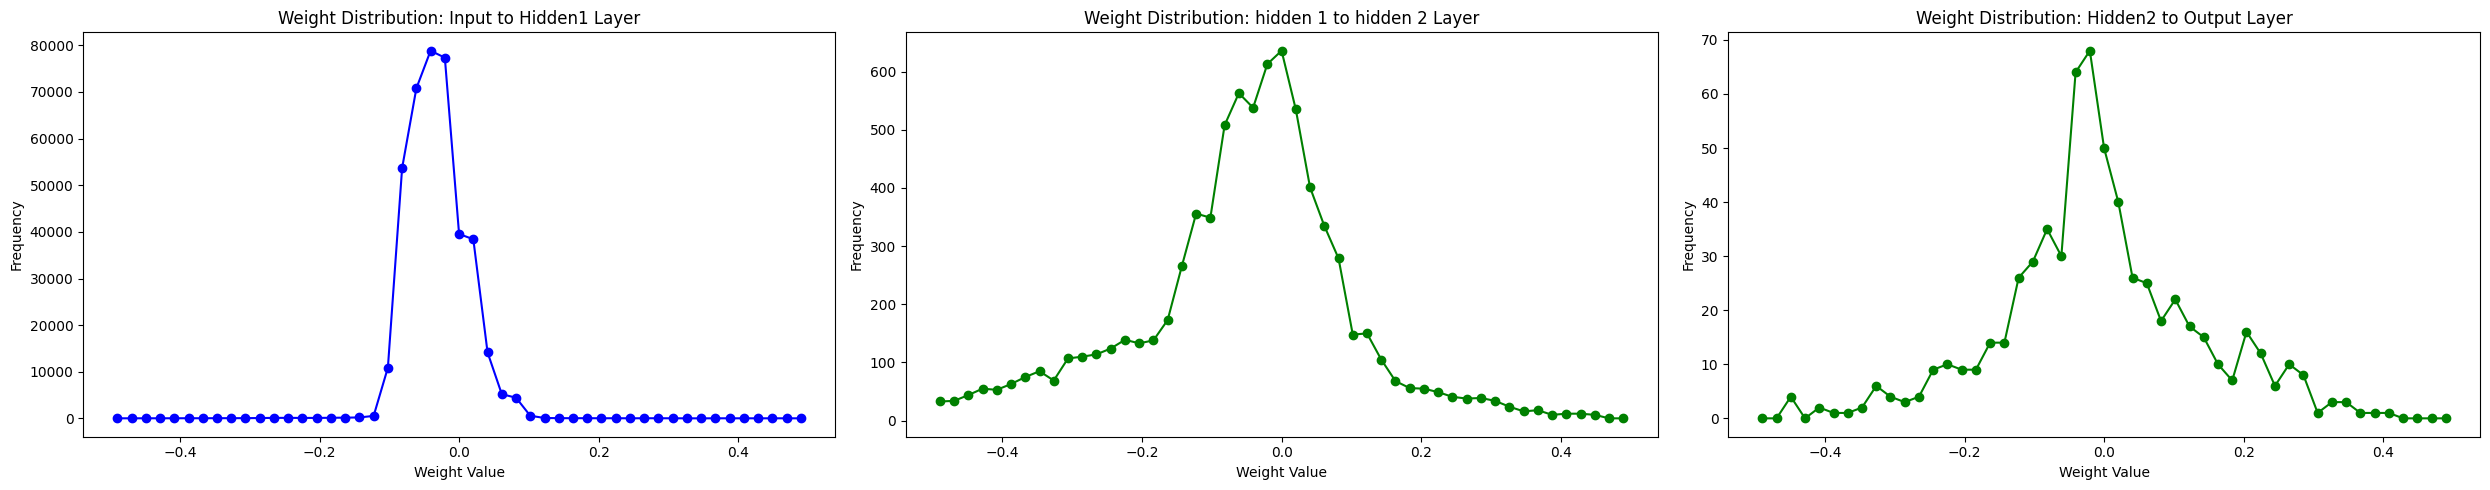

In [217]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [218]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 362843
Number of non-zero weights greater than 0.01 in layer 1: 7567
Number of non-zero weights greater than 0.01 in layer 3: 590


In [219]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.677452857525524, 0.6305172213671206, 0.7136330712499985, 0.7569162069160666, 0.6745698281258717, 0.7630370783342714, 0.7014351270330643, 0.6979292318887728, 0.7395794111998253, 0.6131320633584103, 0.706731621290435, 0.7064309869014346, 0.5685790547674161, 0.6929580731333636, 0.6688293045866764, 0.6976489408170717, 0.6737156186220696, 0.7316187909231762, 0.6788225772935539, 0.6853799311549843, 0.7077860914839987, 0.6902693951894066, 0.7030055783573005, 0.662332899306424, 0.7076940020286712, 0.6655543317630029, 0.7330023915071636, 0.6851779124329893, 0.7203682251536575, 0.6869717134229271, 0.7027739211203073, 0.7356868081993376, 0.6728666578266994, 0.6820253463116653, 0.7286835891508321, 0.6547833704294801, 0.7467466401587661, 0.6653517367503979, 0.6329084780757863, 0.663350652875484, 0.2454627386529511, 0.6880756379934265, 0.684618893417509, 0.7013539883518675, 0.6752862573636732, 0.8650030264979276, 0.5938526348713994, 0.6720202891970457, 0.6929868038752817, 0.6781452445716146, 0.72

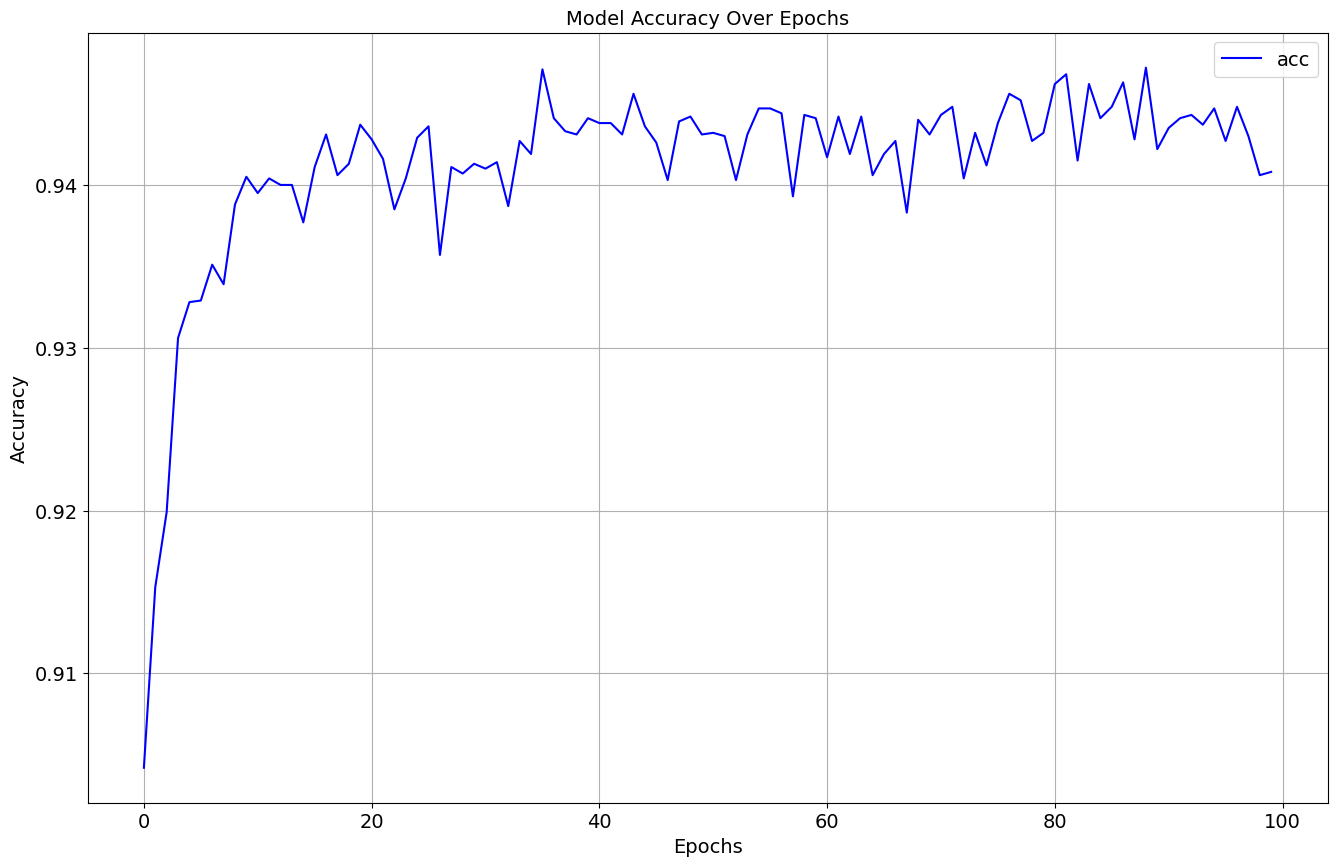

In [220]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [221]:
import pickle
with open('cleanAcc0.pkl', 'wb') as f:
    pickle.dump(acc, f)

torch.save(model.state_dict(), 'cleanModel0.pt')